In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 200 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 3000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 0

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 13.297
Episode: 1 Exploration P: 1.0000 Total reward: -5028.414078645495 SOC: 1.0000 Cumulative_SOC_deviation: 488.2886 Fuel Consumption: 145.5282

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 17.419
Episode: 2 Exploration P: 1.0000 Total reward: -5113.382695710791 SOC: 1.0000 Cumulative_SOC_deviation: 496.3872 Fuel Consumption: 149.5110

../data/driving_cycles/city\01_FTP72_fuds.mat

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autoc

C:\Users\sepri\Desktop\song\experiment\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\sepri\Desktop\song\experiment\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -1049.0429934860629 SOC: 0.3973 Cumulative_SOC_deviation: 104.7642 Fuel Consumption: 1.4013
******************* Test is done *****************



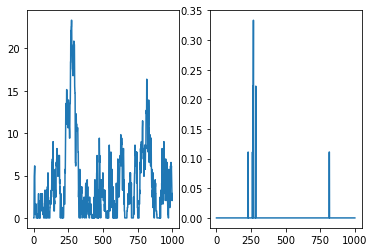

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.560
Episode: 11 Exploration P: 0.7872 Total reward: -4825.389965265867 SOC: 1.0000 Cumulative_SOC_deviation: 470.4336 Fuel Consumption: 121.0536

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.783
Episode: 12 Exploration P: 0.7661 Total reward: -4751.390867414539 SOC: 1.0000 Cumulative_SOC_deviation: 463.3350 Fuel Consumption: 118.0407

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.067
Episode: 13 Exploration P: 0.7456 Total reward: -4757.293819420137 SOC: 1.0000 Cumulative_SOC_deviation: 464.0997 Fuel Consumption: 116.2969

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 85.192
Episode: 14 Exploration P: 0.7257 Total reward: -4716.465633753055 SOC: 1.0000 Cumulative_SOC_deviation: 459.9746 Fuel Consumption: 116.7199

../data/

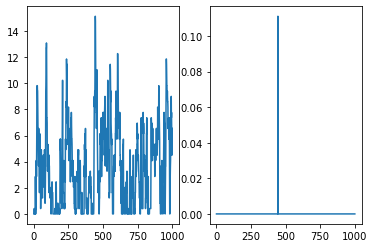

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.309
Episode: 21 Exploration P: 0.6006 Total reward: -4428.678992450166 SOC: 1.0000 Cumulative_SOC_deviation: 432.5868 Fuel Consumption: 102.8111

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.308
Episode: 22 Exploration P: 0.5846 Total reward: -4132.380360070897 SOC: 1.0000 Cumulative_SOC_deviation: 403.8897 Fuel Consumption: 93.4835

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.349
Episode: 23 Exploration P: 0.5690 Total reward: -4177.484969857836 SOC: 1.0000 Cumulative_SOC_deviation: 408.4259 Fuel Consumption: 93.2255

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.621
Episode: 24 Exploration P: 0.5539 Total reward: -4025.587976852894 SOC: 1.0000 Cumulative_SOC_deviation: 392.8627 Fuel Consumption: 96.9607

../data/dri

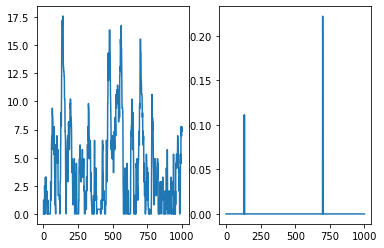

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.781
Episode: 31 Exploration P: 0.4587 Total reward: -3481.312305520173 SOC: 1.0000 Cumulative_SOC_deviation: 339.3483 Fuel Consumption: 87.8292

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.446
Episode: 32 Exploration P: 0.4466 Total reward: -3123.71897533049 SOC: 1.0000 Cumulative_SOC_deviation: 303.8480 Fuel Consumption: 85.2393

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.747
Episode: 33 Exploration P: 0.4348 Total reward: -3219.2533671656092 SOC: 1.0000 Cumulative_SOC_deviation: 313.7491 Fuel Consumption: 81.7621

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.616
Episode: 34 Exploration P: 0.4233 Total reward: -3040.178546347185 SOC: 1.0000 Cumulative_SOC_deviation: 295.8396 Fuel Consumption: 81.7827

../data/driv

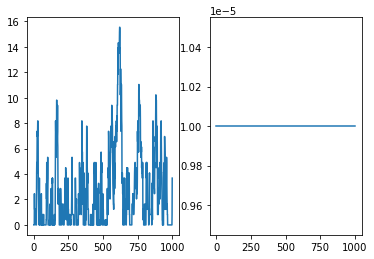

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.849
Episode: 41 Exploration P: 0.3510 Total reward: -1967.3427024212665 SOC: 0.9730 Cumulative_SOC_deviation: 189.2566 Fuel Consumption: 74.7767

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.604
Episode: 42 Exploration P: 0.3418 Total reward: -1847.093159741111 SOC: 0.9153 Cumulative_SOC_deviation: 177.6464 Fuel Consumption: 70.6288

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.666
Episode: 43 Exploration P: 0.3328 Total reward: -2024.5487108064556 SOC: 0.9769 Cumulative_SOC_deviation: 194.9328 Fuel Consumption: 75.2204

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.707
Episode: 44 Exploration P: 0.3240 Total reward: -1398.6278011856837 SOC: 0.9013 Cumulative_SOC_deviation: 132.8123 Fuel Consumption: 70.5050

../data/d

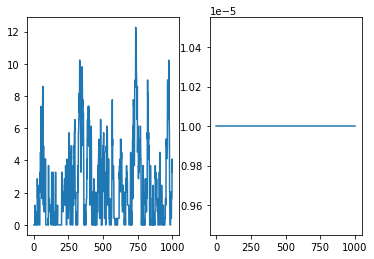

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.707
Episode: 51 Exploration P: 0.2691 Total reward: -710.4769039569552 SOC: 0.7551 Cumulative_SOC_deviation: 65.1549 Fuel Consumption: 58.9280

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.827
Episode: 52 Exploration P: 0.2621 Total reward: -1022.9965876057717 SOC: 0.7861 Cumulative_SOC_deviation: 96.1468 Fuel Consumption: 61.5282

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.056
Episode: 53 Exploration P: 0.2553 Total reward: -784.7702710107703 SOC: 0.7293 Cumulative_SOC_deviation: 72.7328 Fuel Consumption: 57.4422

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.646
Episode: 54 Exploration P: 0.2486 Total reward: -881.2993188665987 SOC: 0.7671 Cumulative_SOC_deviation: 82.1577 Fuel Consumption: 59.7225

../data/driving

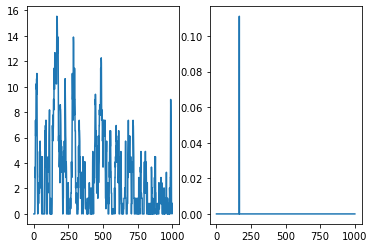

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.719
Episode: 61 Exploration P: 0.2069 Total reward: -1410.0542848788778 SOC: 0.6081 Cumulative_SOC_deviation: 136.2177 Fuel Consumption: 47.8773

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 90.010
Episode: 62 Exploration P: 0.2016 Total reward: -1287.3608571027821 SOC: 0.6103 Cumulative_SOC_deviation: 123.8844 Fuel Consumption: 48.5170

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 93.834
Episode: 63 Exploration P: 0.1964 Total reward: -1649.0092032723467 SOC: 0.5264 Cumulative_SOC_deviation: 160.7075 Fuel Consumption: 41.9341

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.726
Episode: 64 Exploration P: 0.1913 Total reward: -1359.3759281813777 SOC: 0.5401 Cumulative_SOC_deviation: 131.6730 Fuel Consumption: 42.6460

../data/

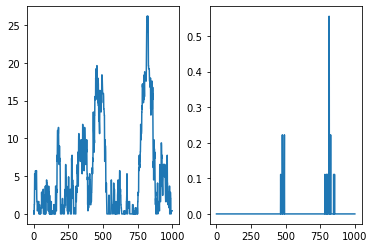

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.258
Episode: 71 Exploration P: 0.1596 Total reward: -2046.9954094225802 SOC: 0.4635 Cumulative_SOC_deviation: 201.0035 Fuel Consumption: 36.9607

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.763
Episode: 72 Exploration P: 0.1556 Total reward: -3060.159430529558 SOC: 0.3326 Cumulative_SOC_deviation: 303.2691 Fuel Consumption: 27.4680

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.602
Episode: 73 Exploration P: 0.1516 Total reward: -3060.2251928160385 SOC: 0.3436 Cumulative_SOC_deviation: 303.1405 Fuel Consumption: 28.8197

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.520
Episode: 74 Exploration P: 0.1478 Total reward: -2824.1890930743502 SOC: 0.3719 Cumulative_SOC_deviation: 279.3481 Fuel Consumption: 30.7079

../data/d

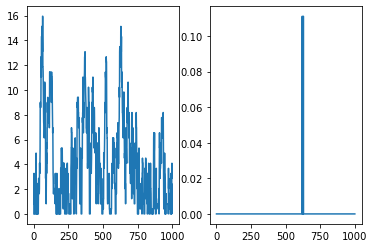

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.688
Episode: 81 Exploration P: 0.1237 Total reward: -838.4838726791419 SOC: 0.6193 Cumulative_SOC_deviation: 78.9407 Fuel Consumption: 49.0769

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.348
Episode: 82 Exploration P: 0.1206 Total reward: -200.62348127428433 SOC: 0.6387 Cumulative_SOC_deviation: 15.4270 Fuel Consumption: 46.3533

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.474
Episode: 83 Exploration P: 0.1176 Total reward: -231.58510315866812 SOC: 0.6117 Cumulative_SOC_deviation: 18.6640 Fuel Consumption: 44.9455

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.030
Episode: 84 Exploration P: 0.1147 Total reward: -155.14859385847433 SOC: 0.6139 Cumulative_SOC_deviation: 10.9967 Fuel Consumption: 45.1813

../data/drivi

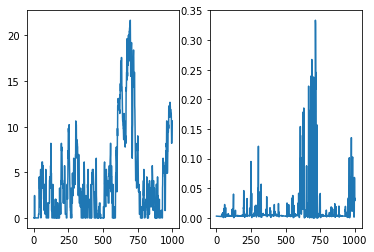

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.163
Episode: 91 Exploration P: 0.0964 Total reward: -146.697308879536 SOC: 0.5989 Cumulative_SOC_deviation: 10.4624 Fuel Consumption: 42.0732

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.985
Episode: 92 Exploration P: 0.0940 Total reward: -134.48050263989765 SOC: 0.6176 Cumulative_SOC_deviation: 9.1509 Fuel Consumption: 42.9714

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.488
Episode: 93 Exploration P: 0.0918 Total reward: -128.53216017836812 SOC: 0.5928 Cumulative_SOC_deviation: 8.6551 Fuel Consumption: 41.9814

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.163
Episode: 94 Exploration P: 0.0896 Total reward: -128.8411097894972 SOC: 0.6095 Cumulative_SOC_deviation: 8.5277 Fuel Consumption: 43.5640

../data/driving_cy

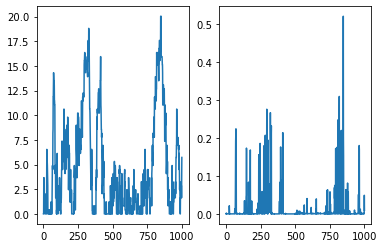

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.444
Episode: 101 Exploration P: 0.0756 Total reward: -115.16048670230013 SOC: 0.6045 Cumulative_SOC_deviation: 7.3267 Fuel Consumption: 41.8936

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.823
Episode: 102 Exploration P: 0.0739 Total reward: -104.18330339513072 SOC: 0.5990 Cumulative_SOC_deviation: 6.2380 Fuel Consumption: 41.8031

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.612
Episode: 103 Exploration P: 0.0721 Total reward: -105.81296367360804 SOC: 0.6051 Cumulative_SOC_deviation: 6.4525 Fuel Consumption: 41.2878

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.840
Episode: 104 Exploration P: 0.0705 Total reward: -111.42695885662509 SOC: 0.6006 Cumulative_SOC_deviation: 6.9662 Fuel Consumption: 41.7650

../data/driv

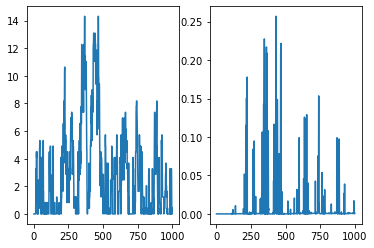

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.586
Episode: 111 Exploration P: 0.0599 Total reward: -148.14440363324172 SOC: 0.5949 Cumulative_SOC_deviation: 10.7232 Fuel Consumption: 40.9123

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.418
Episode: 112 Exploration P: 0.0585 Total reward: -129.23396650390538 SOC: 0.5964 Cumulative_SOC_deviation: 8.8620 Fuel Consumption: 40.6138

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.716
Episode: 113 Exploration P: 0.0572 Total reward: -152.60619526093848 SOC: 0.5972 Cumulative_SOC_deviation: 11.1711 Fuel Consumption: 40.8953

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.381
Episode: 114 Exploration P: 0.0559 Total reward: -123.00388002372617 SOC: 0.5979 Cumulative_SOC_deviation: 8.1460 Fuel Consumption: 41.5436

../data/dr

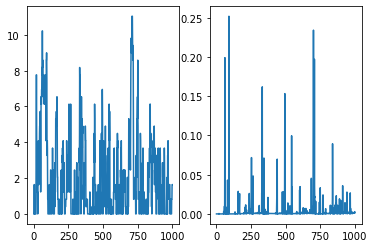

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.183
Episode: 121 Exploration P: 0.0479 Total reward: -180.3855613901565 SOC: 0.5916 Cumulative_SOC_deviation: 14.0421 Fuel Consumption: 39.9650

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.314
Episode: 122 Exploration P: 0.0469 Total reward: -195.0060483160926 SOC: 0.5890 Cumulative_SOC_deviation: 15.4635 Fuel Consumption: 40.3708

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.530
Episode: 123 Exploration P: 0.0459 Total reward: -200.25317810062427 SOC: 0.5880 Cumulative_SOC_deviation: 16.0629 Fuel Consumption: 39.6244

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.026
Episode: 124 Exploration P: 0.0449 Total reward: -167.08431012330007 SOC: 0.5910 Cumulative_SOC_deviation: 12.6906 Fuel Consumption: 40.1779

../data/dr

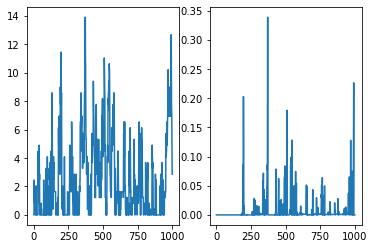

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.790
Episode: 131 Exploration P: 0.0388 Total reward: -152.45229148504538 SOC: 0.5971 Cumulative_SOC_deviation: 11.2082 Fuel Consumption: 40.3705

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.939
Episode: 132 Exploration P: 0.0380 Total reward: -159.73280904434378 SOC: 0.5919 Cumulative_SOC_deviation: 11.9475 Fuel Consumption: 40.2575

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.478
Episode: 133 Exploration P: 0.0373 Total reward: -199.26917069128933 SOC: 0.5907 Cumulative_SOC_deviation: 15.9478 Fuel Consumption: 39.7907

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.897
Episode: 134 Exploration P: 0.0365 Total reward: -191.08413168001624 SOC: 0.5921 Cumulative_SOC_deviation: 15.1277 Fuel Consumption: 39.8071

../data/

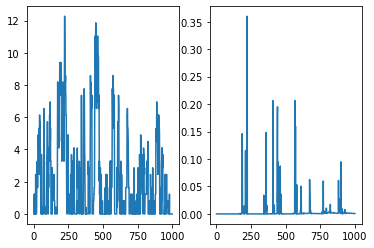

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.990
Episode: 141 Exploration P: 0.0319 Total reward: -240.2772031071504 SOC: 0.5942 Cumulative_SOC_deviation: 20.0536 Fuel Consumption: 39.7411

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.727
Episode: 142 Exploration P: 0.0313 Total reward: -233.94994910037227 SOC: 0.5832 Cumulative_SOC_deviation: 19.4259 Fuel Consumption: 39.6909

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.148
Episode: 143 Exploration P: 0.0307 Total reward: -213.90660946344957 SOC: 0.5920 Cumulative_SOC_deviation: 17.3623 Fuel Consumption: 40.2831

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.340
Episode: 144 Exploration P: 0.0302 Total reward: -190.70477089573106 SOC: 0.5859 Cumulative_SOC_deviation: 15.0698 Fuel Consumption: 40.0069

../data/d

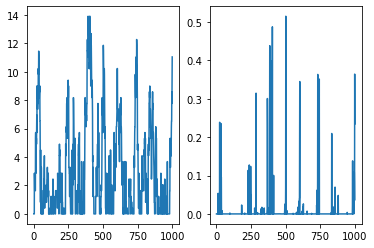

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.070
Episode: 151 Exploration P: 0.0266 Total reward: -132.32323225512997 SOC: 0.6015 Cumulative_SOC_deviation: 9.1568 Fuel Consumption: 40.7557

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.966
Episode: 152 Exploration P: 0.0262 Total reward: -111.16135506391998 SOC: 0.6012 Cumulative_SOC_deviation: 7.0488 Fuel Consumption: 40.6737

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.336
Episode: 153 Exploration P: 0.0257 Total reward: -96.27148530769486 SOC: 0.6037 Cumulative_SOC_deviation: 5.5728 Fuel Consumption: 40.5436

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.350
Episode: 154 Exploration P: 0.0253 Total reward: -156.01822012980713 SOC: 0.6007 Cumulative_SOC_deviation: 11.5702 Fuel Consumption: 40.3167

../data/driv

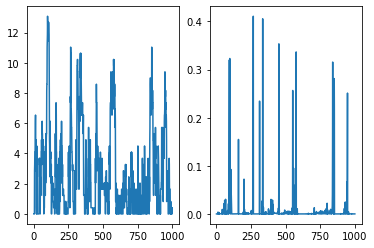

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.504
Episode: 161 Exploration P: 0.0226 Total reward: -91.71387867134834 SOC: 0.5987 Cumulative_SOC_deviation: 5.1575 Fuel Consumption: 40.1384

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.558
Episode: 162 Exploration P: 0.0223 Total reward: -89.97174629648846 SOC: 0.6014 Cumulative_SOC_deviation: 4.9503 Fuel Consumption: 40.4686

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.872
Episode: 163 Exploration P: 0.0220 Total reward: -95.02262138122892 SOC: 0.5979 Cumulative_SOC_deviation: 5.4563 Fuel Consumption: 40.4601

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.808
Episode: 164 Exploration P: 0.0216 Total reward: -96.43544678534852 SOC: 0.5976 Cumulative_SOC_deviation: 5.6671 Fuel Consumption: 39.7649

../data/driving_

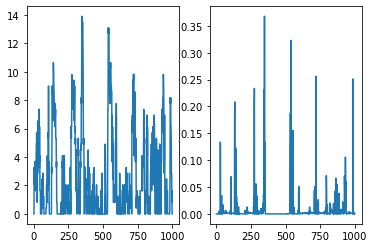

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.332
Episode: 171 Exploration P: 0.0196 Total reward: -108.50606340161477 SOC: 0.5994 Cumulative_SOC_deviation: 6.8329 Fuel Consumption: 40.1769

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.801
Episode: 172 Exploration P: 0.0193 Total reward: -93.32092304493221 SOC: 0.6000 Cumulative_SOC_deviation: 5.3112 Fuel Consumption: 40.2085

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.863
Episode: 173 Exploration P: 0.0191 Total reward: -100.46356741835103 SOC: 0.6000 Cumulative_SOC_deviation: 6.0205 Fuel Consumption: 40.2583

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.670
Episode: 174 Exploration P: 0.0188 Total reward: -117.75372829397341 SOC: 0.5985 Cumulative_SOC_deviation: 7.7298 Fuel Consumption: 40.4557

../data/drivi

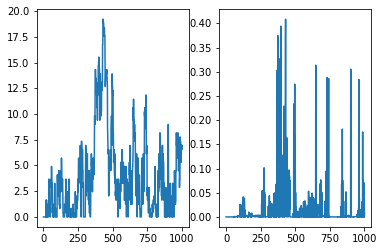

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.290
Episode: 181 Exploration P: 0.0173 Total reward: -120.44725388903089 SOC: 0.6004 Cumulative_SOC_deviation: 7.9965 Fuel Consumption: 40.4818

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.204
Episode: 182 Exploration P: 0.0171 Total reward: -106.54349217687275 SOC: 0.5979 Cumulative_SOC_deviation: 6.5799 Fuel Consumption: 40.7443

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.596
Episode: 183 Exploration P: 0.0169 Total reward: -114.49996356100417 SOC: 0.5967 Cumulative_SOC_deviation: 7.3922 Fuel Consumption: 40.5776

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.458
Episode: 184 Exploration P: 0.0167 Total reward: -112.47297394961308 SOC: 0.5994 Cumulative_SOC_deviation: 7.1943 Fuel Consumption: 40.5300

../data/driv

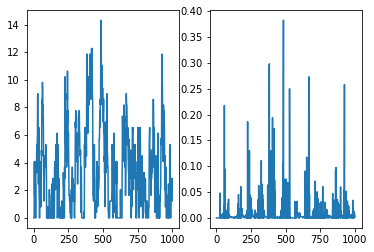

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 75.077
Episode: 191 Exploration P: 0.0155 Total reward: -120.95460012102895 SOC: 0.5976 Cumulative_SOC_deviation: 8.0834 Fuel Consumption: 40.1211

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 76.048
Episode: 192 Exploration P: 0.0154 Total reward: -115.78328636229973 SOC: 0.5993 Cumulative_SOC_deviation: 7.5267 Fuel Consumption: 40.5162

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 75.883
Episode: 193 Exploration P: 0.0152 Total reward: -99.18515786688526 SOC: 0.6004 Cumulative_SOC_deviation: 5.8707 Fuel Consumption: 40.4779

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 75.546
Episode: 194 Exploration P: 0.0151 Total reward: -150.02769544829698 SOC: 0.6030 Cumulative_SOC_deviation: 10.8687 Fuel Consumption: 41.3411

../data/driv

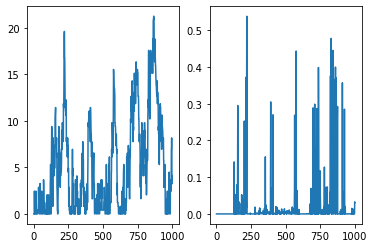

model is saved..


In [15]:
# print(env.version)

num_trials = 1
results_dict = {} 
driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:1]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes):
        i = ep % len(driving_cycle_paths)
        driving_cycle_path =driving_cycle_paths[i]
        print(driving_cycle_path)
        drv_cycle = sio.loadmat(driving_cycle_path)
        driving_cycle = drv_cycle["sch_cycle"][:, 1]

        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
    root = "DDPG_reference_trained_variant_one"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [16]:
with open("DDPG_reference_variant_one.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# results_dict